## Simulating
### General Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from objects_side_of_town import CategoricalFeatureDistribution, MixtureDistribution, Populace, Region
from plot_utilities import removeByLabel,addByLabel,getAllObjects
# matplotlib.use('TKAgg') #easier window management when not using IPython
# matplotlib.rcParams['text.usetex'] = True
number_desired_colors = 6 # https://matplotlib.org/tutorials/colors/colormaps.ht
cmap = plt.cm.get_cmap('nipy_spectral',number_desired_colors)
colors = [cmap(i) for i in range(number_desired_colors)]

Each individual has parameters $\theta =(\theta_u,\theta_p)$. There are two subpopulations:
* For subpopulation $1$, $\theta_u = 1, \theta_p=1$
* For subpopulation $2$, $\theta_u =2, \theta_p = 2$
* Individuals are distributed on a truncated normal distrubtion clipped at the boundaries of the region, with scale parameter equal to $\frac{1}{4}$'th of the width, with mode at fraction $\frac{\theta_u + \theta_p}{4}$ of the width of the region. So, the mode of the distribution of $(2,2)$ individuals is the rightmost boundary of the region; the mode of the distribution of $(1,1)$ individuals is at $50\%$ of the width of the region
* Facilities are distributed according to the same truncated normal distribuition with mode at the rightmost boundary of the region.

In [2]:
theta_u_type1_value = 1
theta_p_type1_value = 1
theta_u_type2_value = 2
theta_p_type2_value = 2

density = 1/5000
sizeRegion = 1000
sizeHub = sizeRegion/25
# nPop = 10000
nPop = int(sizeRegion * sizeRegion * density)
nPerHub = 4
nFacilities = int(nPop/100)

* The `Region` instance `r` is the square of side length `sizeRegion` at the origin in quadrant $1$. Each `Hub` is a circle of radius `sizeHub`, whose center is distributed uniformly randomly in `r` (such that it is fully contained). Hubs can overlap.

* Each subpopulation (a `Populace`) will be divided among the overall `Region` into clusters called `hub`s. Each `hub` has `nPerHub` individuals, and there are just enough hubs to accommodate `nPop` individuals.

*There are `nFacilities` facilities, also distributed uniformly throughout `r`.

In [3]:
## Instantiate subpopulations and Facilities
featureDistribution1 = CategoricalFeatureDistribution(theta_u_type1_value,theta_p_type1_value)
featureDistribution2 = CategoricalFeatureDistribution(theta_u_type2_value,theta_p_type2_value)
mixtureDistribution = MixtureDistribution([featureDistribution1,featureDistribution2],[0.5,0.5])
pop = Populace(mixtureDistribution,nPop)
r = Region(sizeRegion,sizeHub,nPerHub)
r.populate_based_on_sum_exp(pop)
r.generateFacilitiesBasedOnTruncNorm(nFacilities)

## Plotting:

### Plotting objects

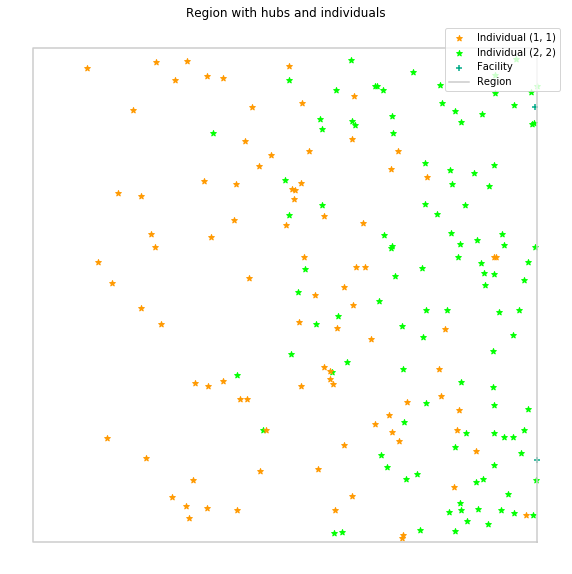

In [4]:
def plotAllObjects():
	fig, ax = plt.subplots(figsize=(10,10))
	plt.axis('off')
	plt.title(f"Region with hubs and individuals")

	## Plot Region
	labelRegion="Region"
	plt.plot(*r.getExteriorCoords(),color=colors.pop(),label=labelRegion)
    ## Plot Individuals
	labelIndividuals = "Individual"
	def plotIndividuals():
		# plt.scatter(*pop.getIndividualCoordinates(),marker="*",c="blue",label="Individual")
		weights = pop.getIndividualParameterSums()
		color_weight_map = {weight : colors.pop() for weight in set(weights)}
		individual_colors = [color_weight_map[weight] for weight in weights]
		individual_labels = [f"{labelIndividuals} {individual.parameters}" for individual in r.individuals]
		for i,individual in enumerate(r.individuals):
			plt.scatter(*individual.location.xy,marker = "*",c=[individual_colors[i]],label=individual_labels[i])
	plotIndividuals()
	## Plot Facilities
	labelFacility = "Facility"
	plt.scatter(*r.getFacilityLocations(),marker="+",c=[colors.pop()],label=labelFacility)
	## Create Legend
	legend_dict = {artist.properties().get('label') : artist for artist in ax.collections.copy() + ax.lines.copy()}
	plt.legend(legend_dict.values(),legend_dict.keys(),loc="upper right")
	plt.show(block=False)
	# plt.close(fig)
	return fig,ax


## Uncomment to view population.
## Comment if taking too long.
fig,ax = plotAllObjects()

In [5]:
### Get distances
def get_distances_to_facilities(individuals):
	# for individual in r.individuals:
	# dist_to_nearest = min([individual.location.distance(hub.geom) for hub in r.hubs])
	return [min([individual.location.distance(facilityLocation) for facilityLocation in r.facilityLocations]) for individual in individuals]

subPops = r.getAllSubpopulations()
subPopDistances = [get_distances_to_facilities(subPop) for subPop in subPops]
subPopColors = [colors.pop() for subpop in subPopDistances]

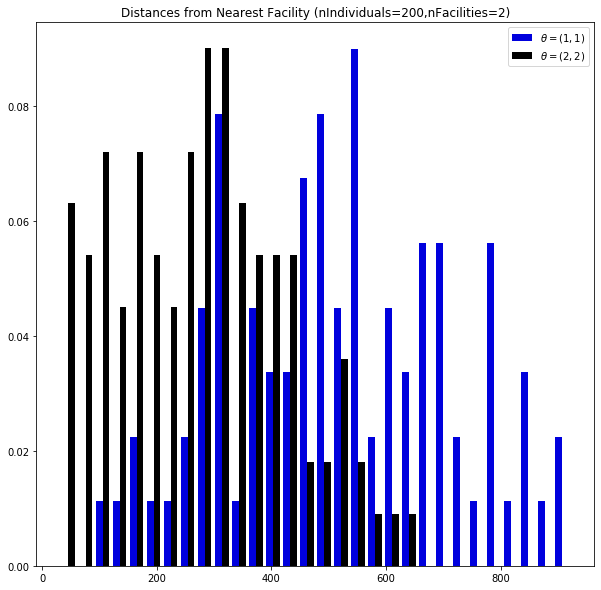

In [6]:
### PLOT 2: Distance Histograms
def plotHistogram():
	fig, ax = plt.subplots(figsize=(10,10))

	plt.title(f"Distances from Nearest Facility (nIndividuals={len(r.individuals)},nFacilities={len(r.facilityLocations)})")
	# distances_total = get_distances_to_facilities(r.individuals)
	num_bins = 30
	weights = [np.zeros_like(oneSubPopDistances) + 1. / len(oneSubPopDistances) for oneSubPopDistances in subPopDistances]
	# ,density=True
	n,bins,histPatches = plt.hist(subPopDistances,num_bins,weights=weights,color = subPopColors)
	for patch,pop in zip(histPatches,subPops):
		patch.set_label( f"$\\theta = {pop[0].parameters}$")
	# legend_dict = {artist.properties().get('label') : artist for artist in ax.collections.copy() + ax.lines.copy()}
	plt.legend(handles=histPatches,loc="upper right")
	plt.show(block=False)
	# plt.close(fig)
	return fig,ax

fig,ax = plotHistogram()

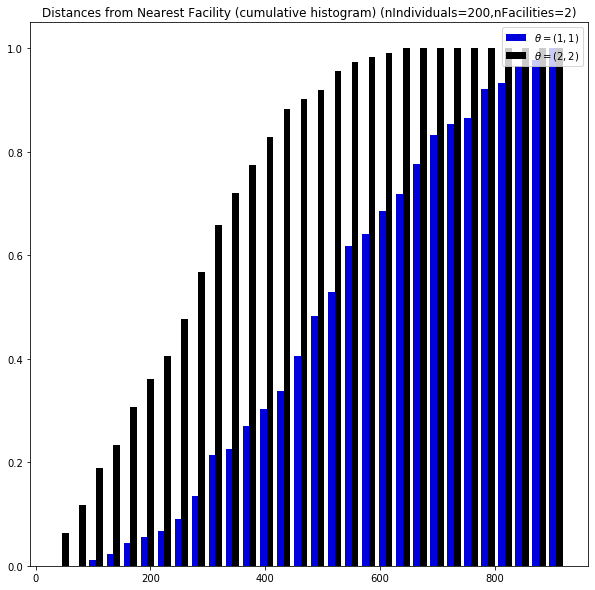

In [7]:
### PLOT 2.5: Cumulative Distance Histograms
def plotCumulativeHistogram():
	fig, ax = plt.subplots(figsize=(10,10))

	plt.title(f"Distances from Nearest Facility (cumulative histogram) (nIndividuals={len(r.individuals)},nFacilities={len(r.facilityLocations)})")
	# distances_total = get_distances_to_facilities(r.individuals)
	num_bins = 30
	n,bins,histPatches = plt.hist(subPopDistances,num_bins,density=True,color = subPopColors,cumulative=True)
	for patch,pop in zip(histPatches,subPops):
		patch.set_label( f"$\\theta = {pop[0].parameters}$")
	# legend_dict = {artist.properties().get('label') : artist for artist in ax.collections.copy() + ax.lines.copy()}
	plt.legend(handles=histPatches,loc="upper right")
	plt.show(block=False)
	# plt.close(fig)
	return fig,ax

fig,ax = plotCumulativeHistogram()


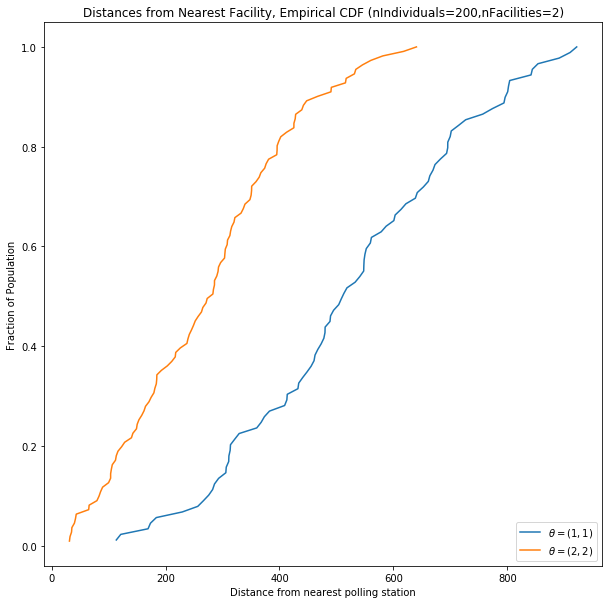

In [8]:
### PLOT 3: Empirical CDF
def plotCDFs():
	fig, ax = plt.subplots(figsize=(10,10))
	plt.title(f"Distances from Nearest Facility, Empirical CDF (nIndividuals={len(r.individuals)},nFacilities={len(r.facilityLocations)})")
	plt.xlabel(f"Distance from nearest polling station")
	plt.ylabel(f"Fraction of Population")

	## TODO: Oversampling?
	## Returns Nx2 numpy.array
	# list_of_tuples =  list(zip(sorted(container), [i/nElts for i in range(1,nElts + 1)])) #list of tuples
	# return list(zip(*list_of_tuples))
	def empiricalCDF(container):
		nElts = len(container)
		return [sorted(container), [i/nElts for i in range(1,nElts + 1)]]

	distanceCDFs = np.array([empiricalCDF(distances) for distances in subPopDistances]).flat
	# [xcoords1,ycoords1,xcoords2,ycoords2,...]
	cdfLines = plt.plot(*distanceCDFs)

	for line,subPop in zip(cdfLines,subPops):
		line.set_label( f"$\\theta = {subPop[0].parameters}$")

	plt.legend(handles=cdfLines,loc="lower right")
	plt.show(block=False)
	# plt.close(fig)
	return fig,ax

fig, ax = plotCDFs()